## Import all requiered packages

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import f1_score
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

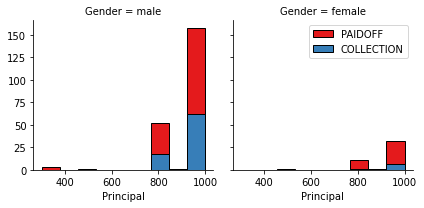

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

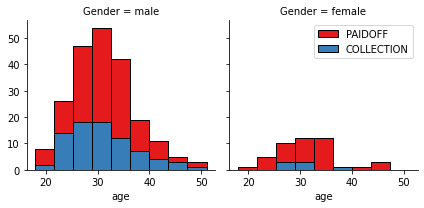

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

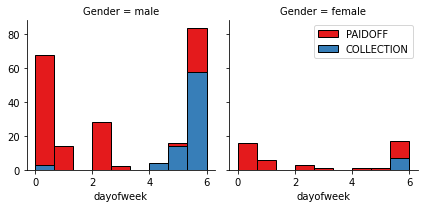

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


## Convert Categorical features to numerical values

Lets convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [16]:
#y = df['loan_status'].values
#y[0:5]

In [17]:
y = df['loan_status']
y.value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [18]:
y.replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)


In [19]:
y = y.values

In [20]:
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Using the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=44)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier

## Choosing Best K


Minimum error:- 0.18571428571428572 at K = 3


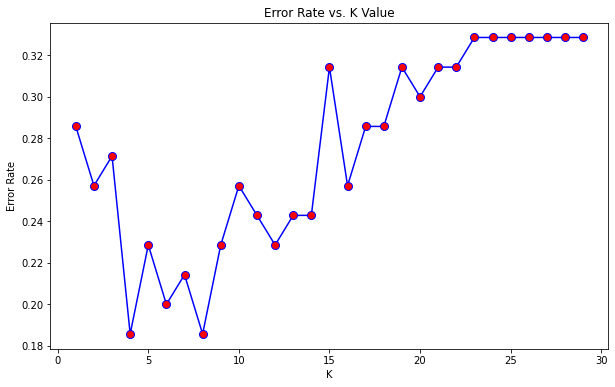

In [24]:
error_rate = []
for i in range(1,30):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', 
         marker='o',markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.8142857142857143 at K = 3


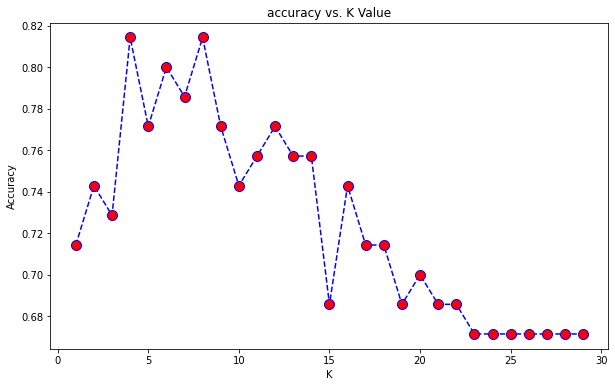

In [25]:
acc = []
from sklearn import metrics
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [26]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train,y_train)
knn

KNeighborsClassifier(n_neighbors=3)

In [27]:
y_predict_knn = knn.predict(X_test)
y_predict_knn[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [28]:
f1_score(y_test,y_predict_knn,average='weighted')

0.7262210893278854

# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
DTree = DecisionTreeClassifier(max_depth = 20)
DTree 

DecisionTreeClassifier(max_depth=20)

In [31]:
DTree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20)

In [32]:
y_predict_DTree = DTree.predict(X_test)
y_predict_DTree[0:5]

array([0, 0, 1, 0, 0], dtype=int64)

In [33]:
f1_score(y_test,y_predict_DTree,average='weighted')

0.6974570629743043

# Support Vector Machine

In [34]:
from sklearn import svm
rbf = svm.SVC(gamma='auto',C=2)
rbf.fit(X_train, y_train) 

SVC(C=2, gamma='auto')

In [35]:
y_predict_SVM_rbf = rbf.predict(X_test)
y_predict_SVM_rbf[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [36]:
f1_score(y_test,y_predict_SVM_rbf,average='weighted')

0.6865800865800866

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01).fit(X_train,y_train)
LR

LogisticRegression(C=0.01)

In [38]:
y_predict_LR = LR.predict(X_test)
y_predict_LR[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [39]:
f1_score(y_test,y_predict_LR,average='weighted')

0.6141676505312869

# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation 

In [41]:
test_df = pd.read_csv('loan_test.csv')

In [42]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])


In [43]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)


In [44]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [45]:
Features = test_df[['Principal','terms','age','Gender','weekend']]
Features = pd.concat([Features,pd.get_dummies(test_df['education'])], axis=1)
Features.drop(['Master or Above'], axis = 1,inplace=True)
Features.head()
X_pre = Features

In [46]:
y_pre = test_df['loan_status']

In [47]:
y_pre.replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y_pre = y_pre.values
y_pre[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [48]:
X_pre= preprocessing.StandardScaler().fit(X_pre).transform(X_pre)
X_pre[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [49]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score


## KNN

In [50]:
y_pre_knn = knn.predict(X_pre)
y_pre_knn[0:5]

array([0, 0, 1, 1, 1], dtype=int64)

In [51]:
f1_score_KNN = f1_score(y_pre, y_pre_knn,average='weighted')
jaccard_similarity_score_KNN =  jaccard_score(y_pre, y_pre_knn)
print("Test set Accuracy: ", f1_score_KNN)
print("Test set Accuracy: ", jaccard_similarity_score_KNN)

Test set Accuracy:  0.6333958054439982
Test set Accuracy:  0.13636363636363635


## Decision Tree

In [52]:
y_pre_DTree = DTree.predict(X_pre)
y_pre_DTree

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [53]:
f1_score_DTree = f1_score(y_pre, y_pre_DTree,average='weighted')
jaccard_similarity_score_DTree =  jaccard_score(y_pre, y_pre_DTree)
print("f1_score:                 ", f1_score_DTree)
print("jaccard_similarity_score: ", jaccard_similarity_score_DTree)

f1_score:                  0.7253086419753088
jaccard_similarity_score:  0.2631578947368421


## SVM

In [54]:
y_pre_SVM = rbf.predict(X_pre)
y_pre_SVM[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [55]:
f1_score_SVM = f1_score(y_pre, y_pre_SVM,average='weighted')
jaccard_similarity_score_SVM =  jaccard_score(y_pre, y_pre_SVM)
print("Test set Accuracy: ", f1_score_SVM)
print("Test set Accuracy: ", jaccard_similarity_score_SVM)

Test set Accuracy:  0.7960222378827031
Test set Accuracy:  0.375


## Logistic Regression	

In [56]:
y_pre_LR = LR.predict(X_pre)
y_pre_LR[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [57]:
from sklearn.metrics import log_loss

In [58]:
f1_score_LR = f1_score(y_pre, y_pre_LR,average='weighted')
jaccard_similarity_score_LR =  jaccard_score(y_pre, y_pre_LR)
log_loss_LR = log_loss(y_pre,LR.predict_proba(X_pre))
print("f1_score:                 ", f1_score_LR)
print("jaccard_similarity_score: ", jaccard_similarity_score_LR)
print("log_loss:                 ", log_loss_LR)

f1_score:                  0.6304176516942475
jaccard_similarity_score:  0.0
log_loss:                  0.5230824549029791


In [59]:
data = {'Algorithm':['KNN','Decision Tree','SVM','LogisticRegression'],
        'Jaccard':[jaccard_similarity_score_KNN,jaccard_similarity_score_DTree,jaccard_similarity_score_SVM,jaccard_similarity_score_LR],
        'F1-score':[f1_score_KNN,f1_score_DTree,f1_score_SVM,f1_score_LR],
        'LogLoss':['NA','NA','NA',log_loss_LR]
       }
Report = pd.DataFrame(data,columns=['Algorithm','Jaccard','F1-score','LogLoss'])

# Report

In [60]:
Report.head()

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.136364,0.633396,NA
1,Decision Tree,0.263158,0.725309,NA
2,SVM,0.375000,0.796022,NA
3,LogisticRegression,0.000000,0.630418,0.523082
